In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [16]:
#load the csvs with the peak information

spe_df = pd.read_csv('PMT7_spe_COMBINED_polya_peak_positions.csv')

#discard non-physical events
spe_df = spe_df[spe_df['polya_peak_pC'] > 0].reset_index(drop=True)

print('SPE')
print(spe_df)

SPE
   voltage  polya_peak_pC  polya_peak_error_pC
0     1750       1.893387             0.046198
1     1800       1.308456             0.014684
2     1850       1.449998             0.011952
3     1900       1.880817             0.012208
4     1950       2.573449             0.032855
5     2000       3.400162             0.024731


In [17]:
#add gain columns to the data frames

def add_gain_columns(df):
    df=df.copy()
    df['gain'] = (df['polya_peak_pC']*(1e-12)/(1.6e-19))
    df['gain_error'] = (df['polya_peak_error_pC']*(1e-12)/(1.6e-19))
    return df

spe_df = add_gain_columns(spe_df)

In [18]:
#find mean gain for each voltage in case of multiple trials

def average_gain_per_voltage(df):
    grouped = df.groupby('voltage')
    mean_gain = grouped['gain'].mean()
    mean_gain_err = grouped['gain_error'].apply(lambda errs: np.sqrt(np.sum(errs**2)) / len(errs)
    )
    
    out = pd.DataFrame({'voltage': mean_gain.index,
        'gain': mean_gain.values,
        'gain_error': mean_gain_err.values})
    
    return out.sort_values('voltage')

spe_avg_gain = average_gain_per_voltage(spe_df)
print(spe_avg_gain)

   voltage          gain     gain_error
0     1750  1.183367e+07  288735.580121
1     1800  8.177853e+06   91776.786742
2     1850  9.062488e+06   74699.378895
3     1900  1.175511e+07   76300.424011
4     1950  1.608406e+07  205343.794242
5     2000  2.125101e+07  154569.137678


In [19]:
#gain model and fitting
def gain_model(V, A, B):
    return A * V**(14 * B)

def fit_gain_curve(voltage, gain, gain_err, ignore_voltage=None):
    mask = np.ones_like(voltage, dtype=bool)

    if ignore_voltage is not None:
        mask &= voltage != ignore_voltage
    
    p0 = [5e-20, 0.7] #initial guesses

    '''
    bounds = (
        [1e-25, 0.2],   # lower bounds: A, B
        [1e-18, 0.9]    # upper bounds: A, B
    )
    popt, pcov = curve_fit(
        gain_model,
        voltage[mask],
        gain[mask],
        sigma=gain_err[mask],
        absolute_sigma=True,
        p0=p0,
        bounds=bounds,
        maxfev=10000
    )
    '''
    popt, pcov = curve_fit(
        gain_model,
        voltage,
        gain,
        sigma=gain_err,
        absolute_sigma=True,
        p0=p0,
        maxfev=10000
    )

    A_fit, B_fit = popt
    err_A, err_B = np.sqrt(np.diag(pcov))

    return A_fit, B_fit, err_A, err_B


A_spe, B_spe, errA_spe, errB_spe = fit_gain_curve(
    spe_avg_gain['voltage'].values,
    spe_avg_gain['gain'].values,
    spe_avg_gain['gain_error'].values
)


V_plot = np.linspace(spe_avg_gain['voltage'].min(),spe_avg_gain['voltage'].max(),300)


In [20]:
#compute chi squareds

def chi_squared(y_data, y_model, y_err, n_params):
    chi2 = np.sum(((y_data-y_model)/y_err)**2)
    dof = len(y_data)-n_params
    chi2_reduced = chi2/dof
    return chi2, chi2_reduced


y_spe_model = gain_model(spe_avg_gain['voltage'].values, A_spe, B_spe)
chi2_spe, chi2_red_spe = chi_squared(
    spe_avg_gain['gain'].values,
    y_spe_model,
    spe_avg_gain['gain_error'].values,
    n_params=2
)

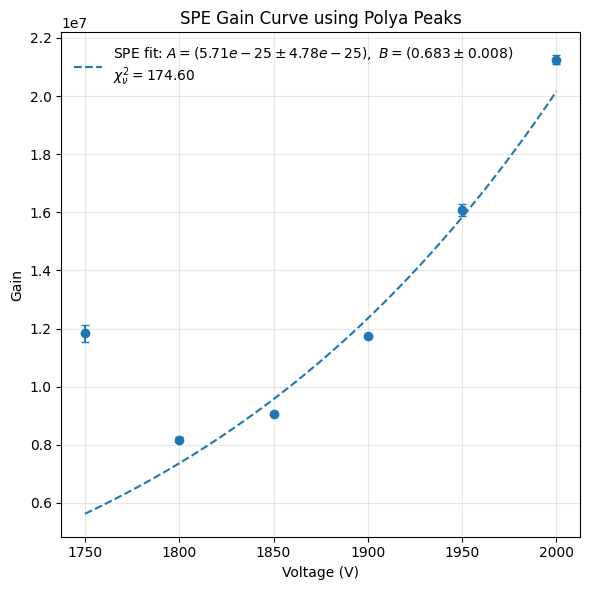

In [21]:
#plot gain curves and gain model = A V^14B separately
plt.figure(figsize=(6, 6))
plt.errorbar(spe_avg_gain['voltage'],spe_avg_gain['gain'],yerr=spe_avg_gain['gain_error'],fmt='o',color='tab:blue',capsize=3)
plt.plot(V_plot,gain_model(V_plot, A_spe, B_spe),'--',color='tab:blue',label=(
        rf'SPE fit: $A=({A_spe:.2e}\pm{errA_spe:.2e}),\ B=({B_spe:.3f}\pm{errB_spe:.3f})$'
        + f'\n$\\chi^2_\\nu={chi2_red_spe:.2f}$'
    ))
plt.xlabel('Voltage (V)')
plt.ylabel('Gain')
plt.title('SPE Gain Curve using Polya Peaks')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend(frameon=False)
plt.show()